## MHI of a video

In [0]:
#@markdown Run this cell to mount Google Drive.

!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [0]:
import numpy as np
import cv2 as cv

MHI_DURATION = 4
DEFAULT_THRESHOLD = 32

def compute_mhi(video_src):
    cam = cv.VideoCapture(video_src)
    _, frame = cam.read()

    h, w = frame.shape[:2]
    prev_frame = frame.copy()
    motion_history = np.zeros((h, w), np.float32)

    while cam.isOpened():
        _, frame = cam.read()
        frame_diff = cv.absdiff(frame, prev_frame)
        gray_diff = cv.cvtColor(frame_diff, cv.COLOR_BGR2GRAY)
        _, motion_mask = cv.threshold(gray_diff, DEFAULT_THRESHOLD, 1,
                                      cv.THRESH_BINARY)
        timestamp = cv.getTickCount() / cv.getTickFrequency()
        cv.motempl.updateMotionHistory(motion_mask, motion_history, timestamp,
                                       MHI_DURATION)
        vis = np.uint8(np.clip((motion_history - (timestamp - MHI_DURATION)) /
                               MHI_DURATION, 0, 1) * 255)
        prev_frame = frame.copy()
    cam.release()
    
    return vis

In [0]:
frame_diff = cv2.absdiff(frame, prev_frame)
gray_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
ret, motion_mask = cv2.threshold(gray_diff, DEFAULT_THRESHOLD, 1,
                                 cv2.THRESH_BINARY)
timestamp = cv2.getTickCount() / cv2.getTickFrequency()
cv2.motempl.updateMotionHistory(motion_mask, motion_history, timestamp,
                                MHI_DURATION)
vis = numpy.uint8(numpy.clip((motion_history - (timestamp - MHI_DURATION)) /
                             MHI_DURATION, 0, 1) * 255)
prev_frame = frame.copy()

### Testing...

In [0]:
def max_value(lst):
    return max([max(sublst) for sublst in lst])

def normalize(vis):
    (nrows, ncols) = vis.shape
    nmhi = [[0 for j in range(ncols)] for i in range(nrows)]
    max_val = max_value(mhi)

    for i in range(nrows):
        for j in range(ncols):
            nmhi[i][j] = int(mhi[i][j] * 255 / max_val)
    
    return nmhi

In [0]:
video_src = '/content/drive/MSRDailyActivity3D/RGB/call cellphone/a04_s03_e01_rgb.avi'
mhi = compute_mhi(video_src)
#mhi = normalize(mhi)

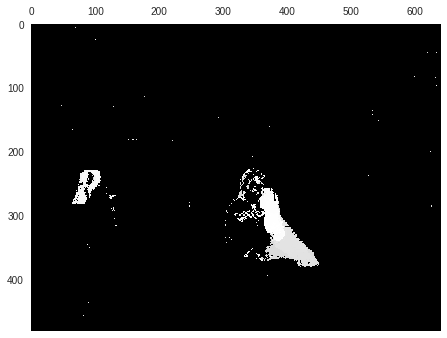

In [0]:
import matplotlib.pyplot as plt

ax = plt.matshow(mhi, cmap=plt.cm.gray)
plt.grid(b=None)
plt.show()